In [1]:
import pandas as pd
import os
import re
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from tqdm import tqdm

# Partie 1 : Traitement des fichiers SRT et RTTM
def parse_srt_to_dataframe(srt_file_path):
    with open(srt_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    blocks = content.strip().split('\n\n')
    data = []
    index = 1
    for block in blocks:
        lines = block.split('\n')
        timing = lines[1]
        start_time, end_time = timing.split(' --> ')
        start_time = start_time.split(" ")[0]
        end_time = end_time.split(" ")[0]
        text = ' '.join(lines[2:])
        data.append([index, start_time, end_time, text])
        index += 1
    srt_df = pd.DataFrame(data, columns=['Index', 'Start Time', 'End Time', 'Text'])
    return srt_df

def parse_rttm_to_dataframe(rttm_file_path):
    columns = ["Type", "File ID", "Channel", "Start Time", "Duration",
               "Orthography", "Speaker Type", "Speaker ID", "Confidence1", "Confidence2"]
    with open(rttm_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = []
    for idx, line in enumerate(lines):
        if line.strip() and not line.startswith('#'):
            row = line.strip().split()
            row.insert(0, idx + 1)
            data.append(row)
    columns.insert(0, "Index")
    rttm_df = pd.DataFrame(data, columns=columns)
    return rttm_df

def get_conversation(srt_file_path, rttm_file_path):
    srt_df = parse_srt_to_dataframe(srt_file_path)
    rttm_df = parse_rttm_to_dataframe(rttm_file_path)
    srt_df["Speaker ID"] = rttm_df["Index"].map(rttm_df.set_index("Index")["Speaker ID"])
    srt_df["File"] = srt_file_path.rsplit("/", 1)[1].split(".")[0]
    return srt_df

def load_all_conversations(data_folder):
    conversations = []
    folders = os.listdir(data_folder)
    for folder in folders:
        srt_file = list(filter(re.compile(".*srt").match, os.listdir(f"{data_folder}/{folder}")))[0]
        rttm_file = list(filter(re.compile(".*rttm").match, os.listdir(f"{data_folder}/{folder}")))[0]
        conversations.append(get_conversation(f"{data_folder}/{folder}/{srt_file}",
                                               f"{data_folder}/{folder}/{rttm_file}"))
    conversations = pd.concat(conversations)
    conversations.loc[(conversations["Speaker ID"] == "patient_1") | (conversations["Speaker ID"] == "patient_2"), "Speaker ID"] = "patient"
    return conversations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Charger les conversations
data_folder = "/content/drive/MyDrive/data"
conversations = load_all_conversations(data_folder)

# Partie 2 : Préparation des données pour l'entraînement
class SpeakerDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df["Text"].tolist()
        self.labels = df["Speaker ID"].astype("category").cat.codes.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [4]:
conversations

,Index,Start Time,End Time,Text,Speaker ID,File
0,1,"00:00:02,149","00:00:06,699",oui bonjour je suis heu le docteur BOCHIN donc...,medecin,reu_covid
1,2,"00:00:08,099","00:00:16,950",oui bonjour heu monsieur madame pardon il y a ...,patient,reu_covid
2,3,"00:00:16,950","00:00:19,150",il a fait le test pour être sûr qu'il a le COVID?,medecin,reu_covid
3,4,"00:00:20,250","00:00:36,550",bah il tousse il a de la fièvre il a mal parto...,patient,reu_covid
4,5,"00:00:36,750","00:00:40,849",et heu est ce que quelqu'un a fait le test pou...,medecin,reu_covid
...,...,...,...,...,...,...
30,31,"00:02:03,220","00:02:04,560",je répète trois fois la même chose,patient,dj_2022_3_mois_paracetamol
31,32,"00:02:04,619","00:02:08,320",c'est heu c'est pour ça qu'on envoie les secou...,medecin,dj_2022_3_mois_paracetamol
32,33,"00:02:08,899","00:02:09,539",d'accord,patient,dj_2022_3_mois_paracetamol
33,34,"00:02:09,709","00:02:10,399",au revoir,medecin,dj_2022_3_mois_paracetamol


In [6]:
def clean_text(text):
    # Mettre en minuscule et normaliser les espaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Normaliser les espaces (ex. multiple espaces en un seul
    # Retirer les espaces supplémentaires qui pourraient apparaître après la suppression
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Appliquer la fonction de nettoyage à votre dataset
conversations["Text"] = conversations["Text"].apply(clean_text)

In [8]:
# Initialisation du tokenizer et dataset
from torch.utils.data import random_split
model_name = 'roberta-base'   # Modèle français
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lowercase=False)
dataset = SpeakerDataset(conversations, tokenizer)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:

# Partie 3 : Modèle et entraînement
class CustomModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Initialiser le modèle
num_labels = len(conversations["Speaker ID"].unique())
model = CustomModel(model_name, num_labels)

# Optimiseur et dispositif
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:

# Fonction d'entraînement
def train_model(model, optimizer, train_loader, val_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            optimizer.zero_grad()
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

        train_acc = total_correct / len(train_loader.dataset)
        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Fonction d'évaluation
def evaluate_model(model, val_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

    val_acc = total_correct / len(val_loader.dataset)
    return total_loss, val_acc

# Entraîner le modèle
train_model(model, optimizer, train_loader, val_loader, epochs=10)

# Rapport final
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = (
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["labels"].to(device),
        )
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


Epoch 1/10: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch 1: Train Acc: 0.6977, Val Acc: 0.8139


Epoch 2/10: 100%|██████████| 78/78 [00:44<00:00,  1.75it/s]


Epoch 2: Train Acc: 0.8037, Val Acc: 0.7961


Epoch 3/10: 100%|██████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch 3: Train Acc: 0.8256, Val Acc: 0.7783


Epoch 4/10: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch 4: Train Acc: 0.8563, Val Acc: 0.8350


Epoch 5/10: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch 5: Train Acc: 0.8701, Val Acc: 0.8447


Epoch 6/10: 100%|██████████| 78/78 [00:47<00:00,  1.66it/s]


Epoch 6: Train Acc: 0.8964, Val Acc: 0.8414


Epoch 7/10: 100%|██████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch 7: Train Acc: 0.8996, Val Acc: 0.8544


Epoch 8/10: 100%|██████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch 8: Train Acc: 0.9130, Val Acc: 0.8414


Epoch 9/10: 100%|██████████| 78/78 [00:47<00:00,  1.63it/s]


Epoch 9: Train Acc: 0.9219, Val Acc: 0.8301


Epoch 10/10: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch 10: Train Acc: 0.9272, Val Acc: 0.8382
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       328
           1       0.80      0.88      0.84       290

    accuracy                           0.84       618
   macro avg       0.84      0.84      0.84       618
weighted avg       0.84      0.84      0.84       618



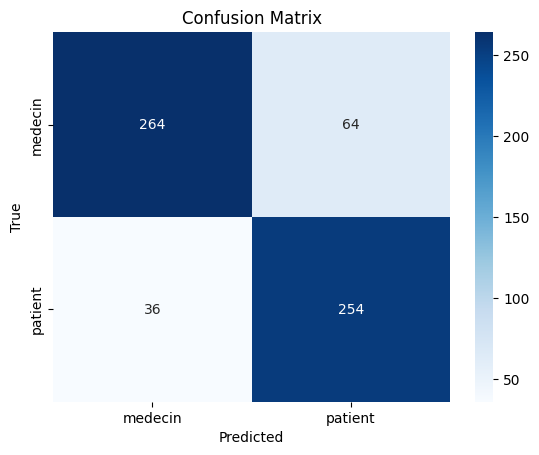

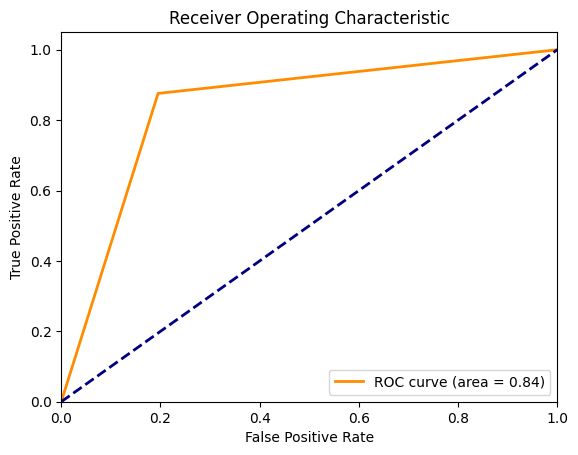

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calcul de la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=conversations["Speaker ID"].unique(), yticklabels=conversations["Speaker ID"].unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Pour les courbes ROC
fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)  # Pos label 1 pour un exemple binaire
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encodage des labels
label_encoder = LabelEncoder()
conversations["Speaker ID Encoded"] = label_encoder.fit_transform(conversations["Speaker ID"])

# Division en ensembles d'entraînement et de test
X = conversations["Text"]
y = conversations["Speaker ID Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Entraînement du modèle
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Prédictions
y_pred = clf.predict(X_test_tfidf)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.8365695792880259
              precision    recall  f1-score   support

     medecin       0.80      0.89      0.84       306
     patient       0.88      0.79      0.83       312

    accuracy                           0.84       618
   macro avg       0.84      0.84      0.84       618
weighted avg       0.84      0.84      0.84       618



In [14]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement du modèle
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_rf = rf_clf.predict(X_test_tfidf)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Accuracy: 0.8171521035598706
              precision    recall  f1-score   support

     medecin       0.80      0.84      0.82       306
     patient       0.84      0.79      0.81       312

    accuracy                           0.82       618
   macro avg       0.82      0.82      0.82       618
weighted avg       0.82      0.82      0.82       618

